# Setup

In [ ]:
# Célula 0 - Importações
# Importações essenciais para o projeto
import ast
import re
import os
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub

from datetime import datetime
from collections import Counter

from sklearn.cluster import KMeans, DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

import plotly.express as px
from mpl_toolkits.mplot3d import Axes3D

In [2]:
# Célula 0.1 - Configurações
# Diretório de Armazenamento dos Dados
data_dir = "C:/ML/Anime/data"

# Normalização dos dados
scaler = MinMaxScaler()

# Dataset

In [ ]:
# Célula 1 - Download e Organização do Dataset
# Definindo o diretório de dados
'''os.makedirs(data_dir, exist_ok=True) 

# Realizando o download do dataset
path = kagglehub.dataset_download("marlesson/myanimelist-dataset-animes-profiles-reviews")

# Movendo os arquivos para o diretório de dados
for file in os.listdir(path):
    os.rename(os.path.join(path, file), os.path.join(data_dir, file))

print("Dataset organizado em:", data_dir)'''

In [11]:
# Célula 1.1 - Leitura dos Dados
df_animes = pd.read_csv("data/animes.csv")
df_reviews = pd.read_csv("data/reviews.csv")
df_profiles = pd.read_csv("data/profiles.csv")

print('Arquivo animes.csv:')
print(df_animes.columns)
print('Dimensões:', df_animes.shape)

print('\nArquivo reviews.csv:')
print(df_reviews.columns)  
print('Dimensões:', df_reviews.shape) 

print('\nArquivo profiles.csv:')
print(df_profiles.columns)  
print('Dimensões:', df_profiles.shape) 

Arquivo animes.csv:
Index(['uid', 'title', 'synopsis', 'genre', 'aired', 'episodes', 'members',
       'popularity', 'ranked', 'score', 'img_url', 'link'],
      dtype='object')
Dimensões: (19311, 12)

Arquivo reviews.csv:
Index(['uid', 'profile', 'anime_uid', 'text', 'score', 'scores', 'link'], dtype='object')
Dimensões: (192112, 7)

Arquivo profiles.csv:
Index(['profile', 'gender', 'birthday', 'favorites_anime', 'link'], dtype='object')
Dimensões: (81727, 5)


In [ ]:
# Célula 1.2 - União dos Arquivos

# Selecionar colunas do dataset animes.csv
animes_columns = ['uid', 'title', 'synopsis', 'genre', 'episodes', 'members', 'popularity', 'ranked', 'img_url', 'link']
df_animes_reduced = df_animes[animes_columns].copy()  # Garantir cópia explícita

# Selecionar colunas do dataset reviews.csv
reviews_columns = ['anime_uid', 'scores', 'profile']  # Incluímos 'profile' para cálculos posteriores
df_reviews_reduced = df_reviews[reviews_columns].copy()  # Garantir cópia explícita

# Alterando o nome da coluna para corresponder ao dataset de animes
df_reviews_reduced = df_reviews_reduced.rename(columns={'anime_uid': 'uid'})

# Trabalhar com uma cópia da coluna favorites_anime para contagem
favorites_anime_temp = df_profiles['favorites_anime'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else []
)
favorites_anime_temp = favorites_anime_temp.apply(
    lambda x: [int(uid) for uid in x] if isinstance(x, list) else []
)

all_favorites = [uid for favorites in favorites_anime_temp for uid in favorites]
favorite_counts = Counter(all_favorites)

# Adicionar a contagem de favoritos ao dataset de animes
df_animes_reduced['favorites_count'] = df_animes_reduced['uid'].map(lambda x: favorite_counts.get(x, 0))

# União dos datasets animes e reviews
df_combined = pd.merge(df_animes_reduced, df_reviews_reduced, on='uid', how='inner')  # Apenas correspondências

# Salvando o dataset combinado
final_dataset_path = os.path.join(data_dir, "dataset_final_v2.csv")  # Adicionando o sufixo _v2
df_combined.to_csv(final_dataset_path, index=False)

print(f"Dataset final salvo em: {final_dataset_path}")
print(f"Dimensões do dataset combinado: {df_combined.shape}")

In [ ]:
# Preencher os valores nulos na coluna 'ranked' com 0
df_combined['ranked'] = df_combined['ranked'].fillna(0).astype(np.int16)

# Verificar se ainda existem valores nulos na coluna
print(f"Valores nulos após preenchimento: {df_combined['ranked'].isna().sum()}")

## Engenharia de Dados

In [ ]:
# Célula 1.3 - Processar as Colunas 'genre', 'scores' e Calcular 'relevance'

# Processar a coluna 'genre'
# Converter strings para listas de gêneros
df_combined['genre'] = df_combined['genre'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else [])

# Identificar todos os gêneros únicos no dataset
unique_genres = set(genre for genres in df_combined['genre'] for genre in genres)

# Criar colunas binárias para cada gênero
for genre in unique_genres:
    df_combined[genre] = df_combined['genre'].apply(lambda x: 1 if genre in x else 0)

# Ordenar as listas de gêneros para padronização
df_combined['genre_sorted'] = df_combined['genre'].apply(lambda x: ",".join(sorted(x)))

# Mapear cada combinação única de gêneros para um valor numérico
unique_genre_combinations = df_combined['genre_sorted'].unique()
genre_mapping = {comb: idx + 1 for idx, comb in enumerate(unique_genre_combinations)}
df_combined['genre_mapped'] = df_combined['genre_sorted'].map(genre_mapping)

# Remover a coluna auxiliar 'genre_sorted' (se desejado)
df_combined.drop(columns=['genre_sorted'], inplace=True)

# Processar a coluna 'scores'
# Converter strings para dicionários
df_combined['scores'] = df_combined['scores'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else {})

# Criar colunas para as categorias de pontuação com prefixo 'score_'
score_categories = ['Overall', 'Story', 'Animation', 'Sound', 'Character', 'Enjoyment']

for category in score_categories:
    column_name = f"score_{category.lower()}"  # Adiciona o prefixo
    df_combined[column_name] = df_combined['scores'].apply(lambda x: int(x.get(category, 0)))

# Normalizar 'favorites_count' e 'score_overall'
scaler = MinMaxScaler()

df_combined['favorites_count_norm'] = scaler.fit_transform(df_combined[['favorites_count']])
df_combined['score_overall_norm'] = scaler.fit_transform(df_combined[['score_overall']])

# Calcular a métrica de relevância
alpha = 0.5  # Peso para favoritos
beta = 0.5   # Peso para pontuação geral (score_overall)
df_combined['relevance'] = alpha * df_combined['favorites_count_norm'] + beta * df_combined['score_overall_norm']

# Remover a coluna original 'scores' (se desejado)
df_combined.drop(columns=['scores'], inplace=True)

# Exibir o resultado
print("Colunas adicionadas para gêneros, pontuações e relevância!")
print("Novas dimensões do dataset:", df_combined.shape)

# Salvar o dataset atualizado
updated_dataset_path = os.path.join(data_dir, "dataset_final_processed_v2.csv")  # Sufixo _v2
df_combined.to_csv(updated_dataset_path, index=False)
print(f"Dataset processado salvo em: {updated_dataset_path}")

# EAD

In [9]:
# Carregar o dataset final completo
df = pd.read_csv("data/dataset_final_processed_v2.csv")

### Análise Descritiva

In [10]:
# Célula 2 - Análise Exploratória de Dados	
# Resumo inicial
print("Dimensões do dataset:", df.shape)
print("Colunas do dataset:", df.columns)

# Estatísticas descritivas
print("\nEstatísticas Descritivas para colunas numéricas:")
print(df.describe())

Dimensões do dataset: (317479, 65)
Colunas do dataset: Index(['uid', 'title', 'synopsis', 'genre', 'episodes', 'members',
       'popularity', 'ranked', 'img_url', 'link', 'favorites_count', 'profile',
       'Seinen', 'Horror', 'Harem', 'Ecchi', 'Space', 'Shoujo Ai', 'Fantasy',
       'Mystery', 'Kids', 'Thriller', 'Cars', 'Action', 'Vampire',
       'Martial Arts', 'Mecha', 'Comedy', 'Sci-Fi', 'Drama', 'Yuri',
       'Dementia', 'Super Power', 'Psychological', 'Hentai', 'Slice of Life',
       'Adventure', 'Military', 'Shoujo', 'Game', 'Supernatural', 'Yaoi',
       'Sports', 'Demons', 'Parody', 'Josei', 'School', 'Romance',
       'Historical', 'Shounen', 'Samurai', 'Music', 'Shounen Ai', 'Police',
       'Magic', 'genre_mapped', 'score_overall', 'score_story',
       'score_animation', 'score_sound', 'score_character', 'score_enjoyment',
       'favorites_count_norm', 'score_overall_norm', 'relevance'],
      dtype='object')

Estatísticas Descritivas para colunas numéricas:
       

### Distribuições

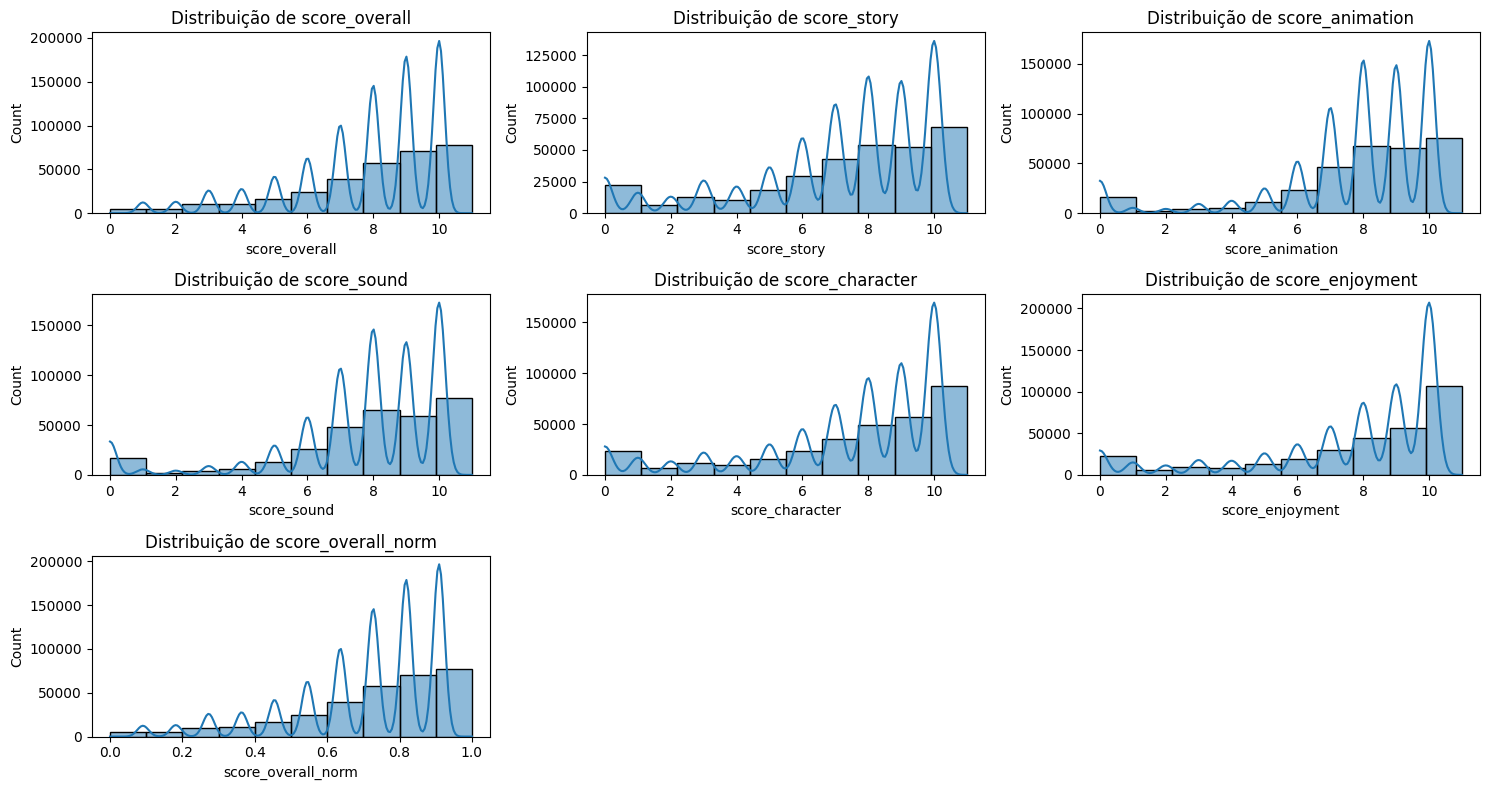

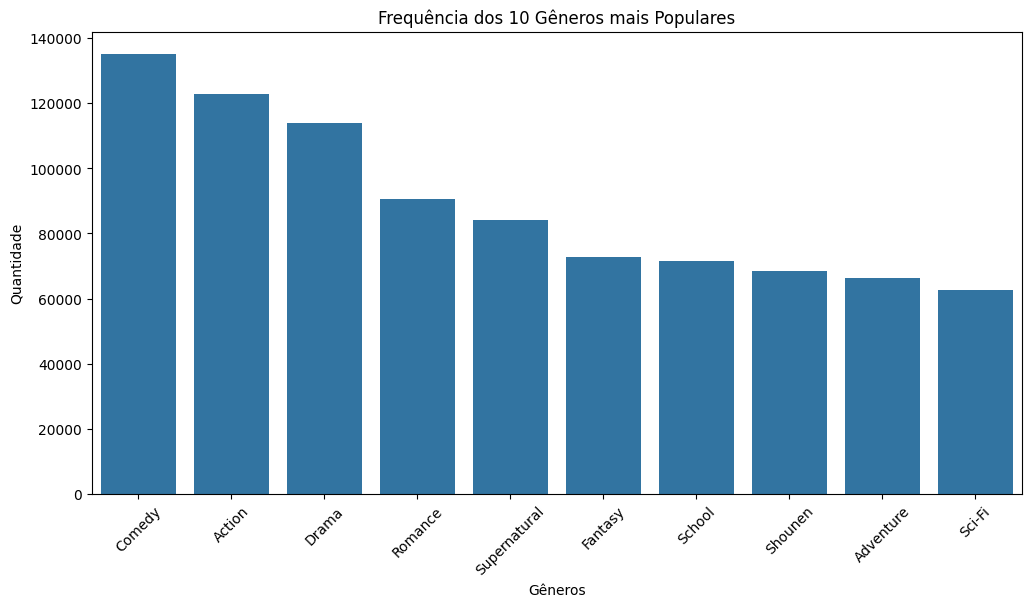

In [11]:
# Célula 2.1 - EDA: Estatísticas Descritivas e Distribuições
# Distribuição de Scores (Histograma)
score_columns = [col for col in df.columns if col.startswith("score_")]

plt.figure(figsize=(15, 8))
for i, col in enumerate(score_columns, 1):
    plt.subplot(3, 3, i)
    sns.histplot(df[col], kde=True, bins=10)
    plt.title(f"Distribuição de {col}")
plt.tight_layout()
plt.show()

# Distribuição de Gêneros (Contagem)
genre_columns = ['Shounen', 'Super Power', 'Adventure', 'Military', 'Game', 'Comedy', 'Sports', 'Shoujo Ai',
                'Action', 'Ecchi', 'Sci-Fi', 'Thriller', 'Yaoi', 'Romance', 'Samurai',
                'Shounen Ai', 'Josei', 'Slice of Life', 'Cars', 'Hentai', 'Mystery',
                'Mecha', 'School', 'Psychological', 'Space', 'Horror', 'Historical',
                'Dementia', 'Drama', 'Demons', 'Seinen', 'Supernatural', 'Vampire',
                'Kids', 'Shoujo', 'Parody', 'Martial Arts', 'Music', 'Fantasy', 'Magic',
                'Police', 'Yuri', 'Harem']

# Calcular a frequência dos gêneros
genre_counts = df[list(genre_columns)].sum().sort_values(ascending=False)

# Plotar o Top 10
plt.figure(figsize=(12, 6))
sns.barplot(x=genre_counts.index[:10], y=genre_counts.values[:10])
plt.title("Frequência dos 10 Gêneros mais Populares")
plt.ylabel("Quantidade")
plt.xlabel("Gêneros")
plt.xticks(rotation=45)
plt.show()

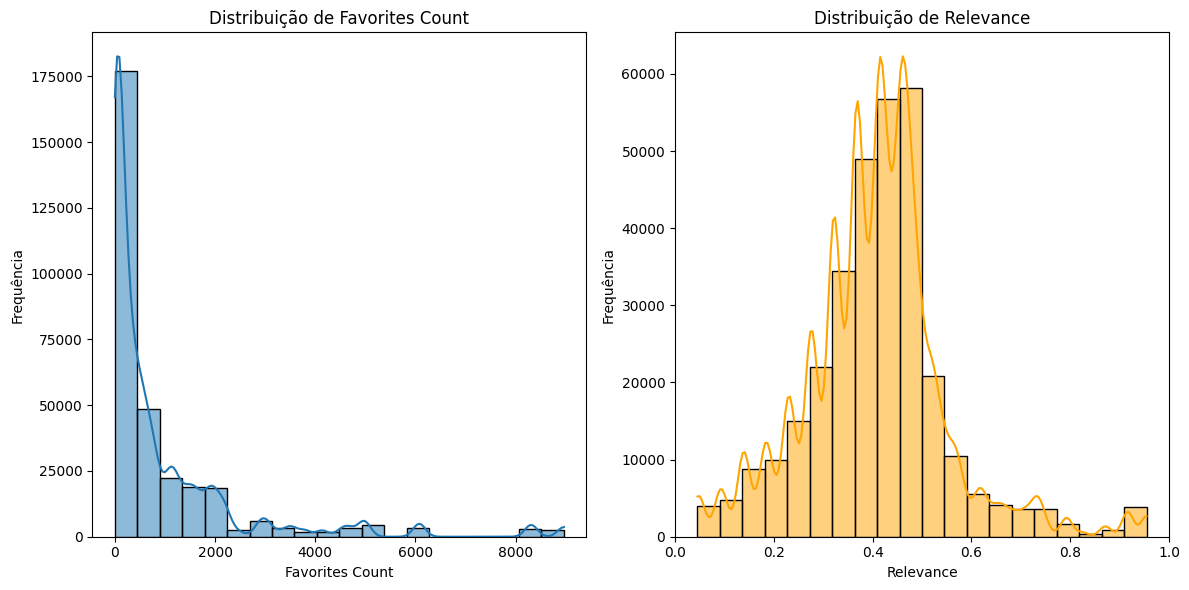

In [12]:
# Célula 2.1(b) - Distribuição de 'favorites_count' e 'relevance'

plt.figure(figsize=(12, 6))

# Histograma para favorites_count
plt.subplot(1, 2, 1)
sns.histplot(df['favorites_count'], kde=True, bins=20)
plt.title("Distribuição de Favorites Count")
plt.xlabel("Favorites Count")
plt.ylabel("Frequência")

# Histograma para relevance
plt.subplot(1, 2, 2)
sns.histplot(df['relevance'], kde=True, bins=20, color='orange')
plt.title("Distribuição de Relevance")
plt.xlabel("Relevance")
plt.ylabel("Frequência")

plt.tight_layout()
plt.show()


Top 10 Agrupamentos de Gêneros por Relevance:
genre_mapped
4      0.816714
345    0.787529
433    0.739362
12     0.697332
442    0.665422
436    0.659229
445    0.658503
361    0.589840
324    0.582706
179    0.579523
Name: relevance, dtype: float64


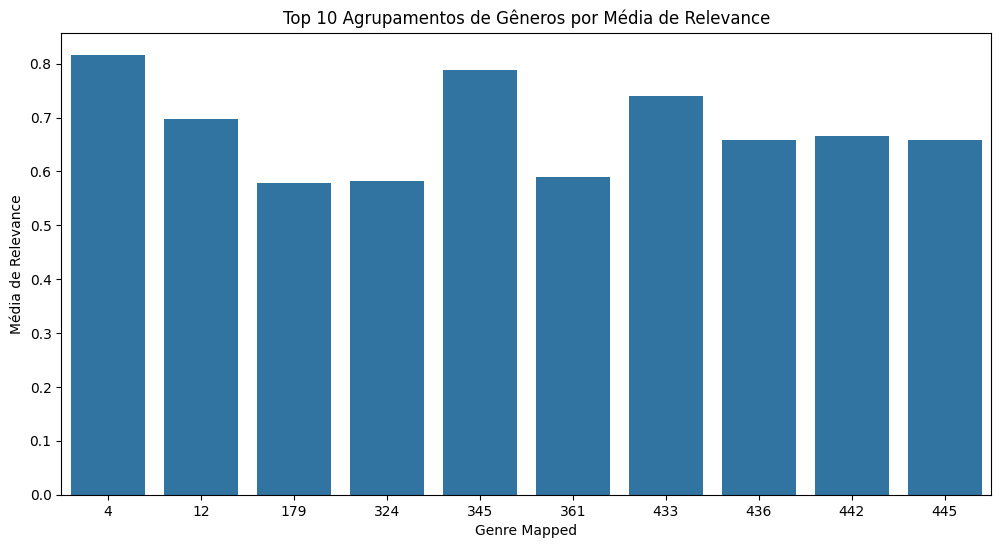

In [14]:
# Célula 2.1(c) - Média de 'relevance' por 'genre_mapped'

# Calcular média de relevance por agrupamento de gêneros
relevance_by_genre = df.groupby('genre_mapped')['relevance'].mean().sort_values(ascending=False)

# Exibir os 10 principais agrupamentos
print("Top 10 Agrupamentos de Gêneros por Relevance:")
print(relevance_by_genre.head(10))

# Visualização
plt.figure(figsize=(12, 6))
sns.barplot(x=relevance_by_genre.head(10).index, y=relevance_by_genre.head(10).values)
plt.title("Top 10 Agrupamentos de Gêneros por Média de Relevance")
plt.xlabel("Genre Mapped")
plt.ylabel("Média de Relevance")
plt.show()


### Correlações

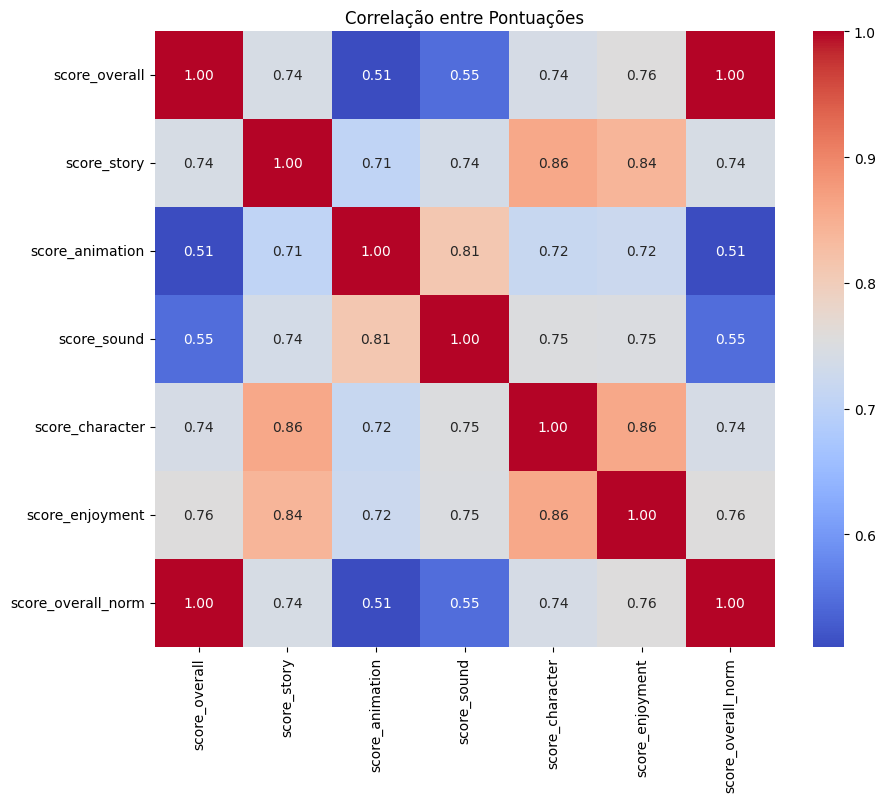

In [15]:
# Célula 2.2(a) - Heatmap de Correlação entre Pontuações
plt.figure(figsize=(10, 8))
correlation = df[score_columns].corr()
sns.heatmap(correlation, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlação entre Pontuações")
plt.show()

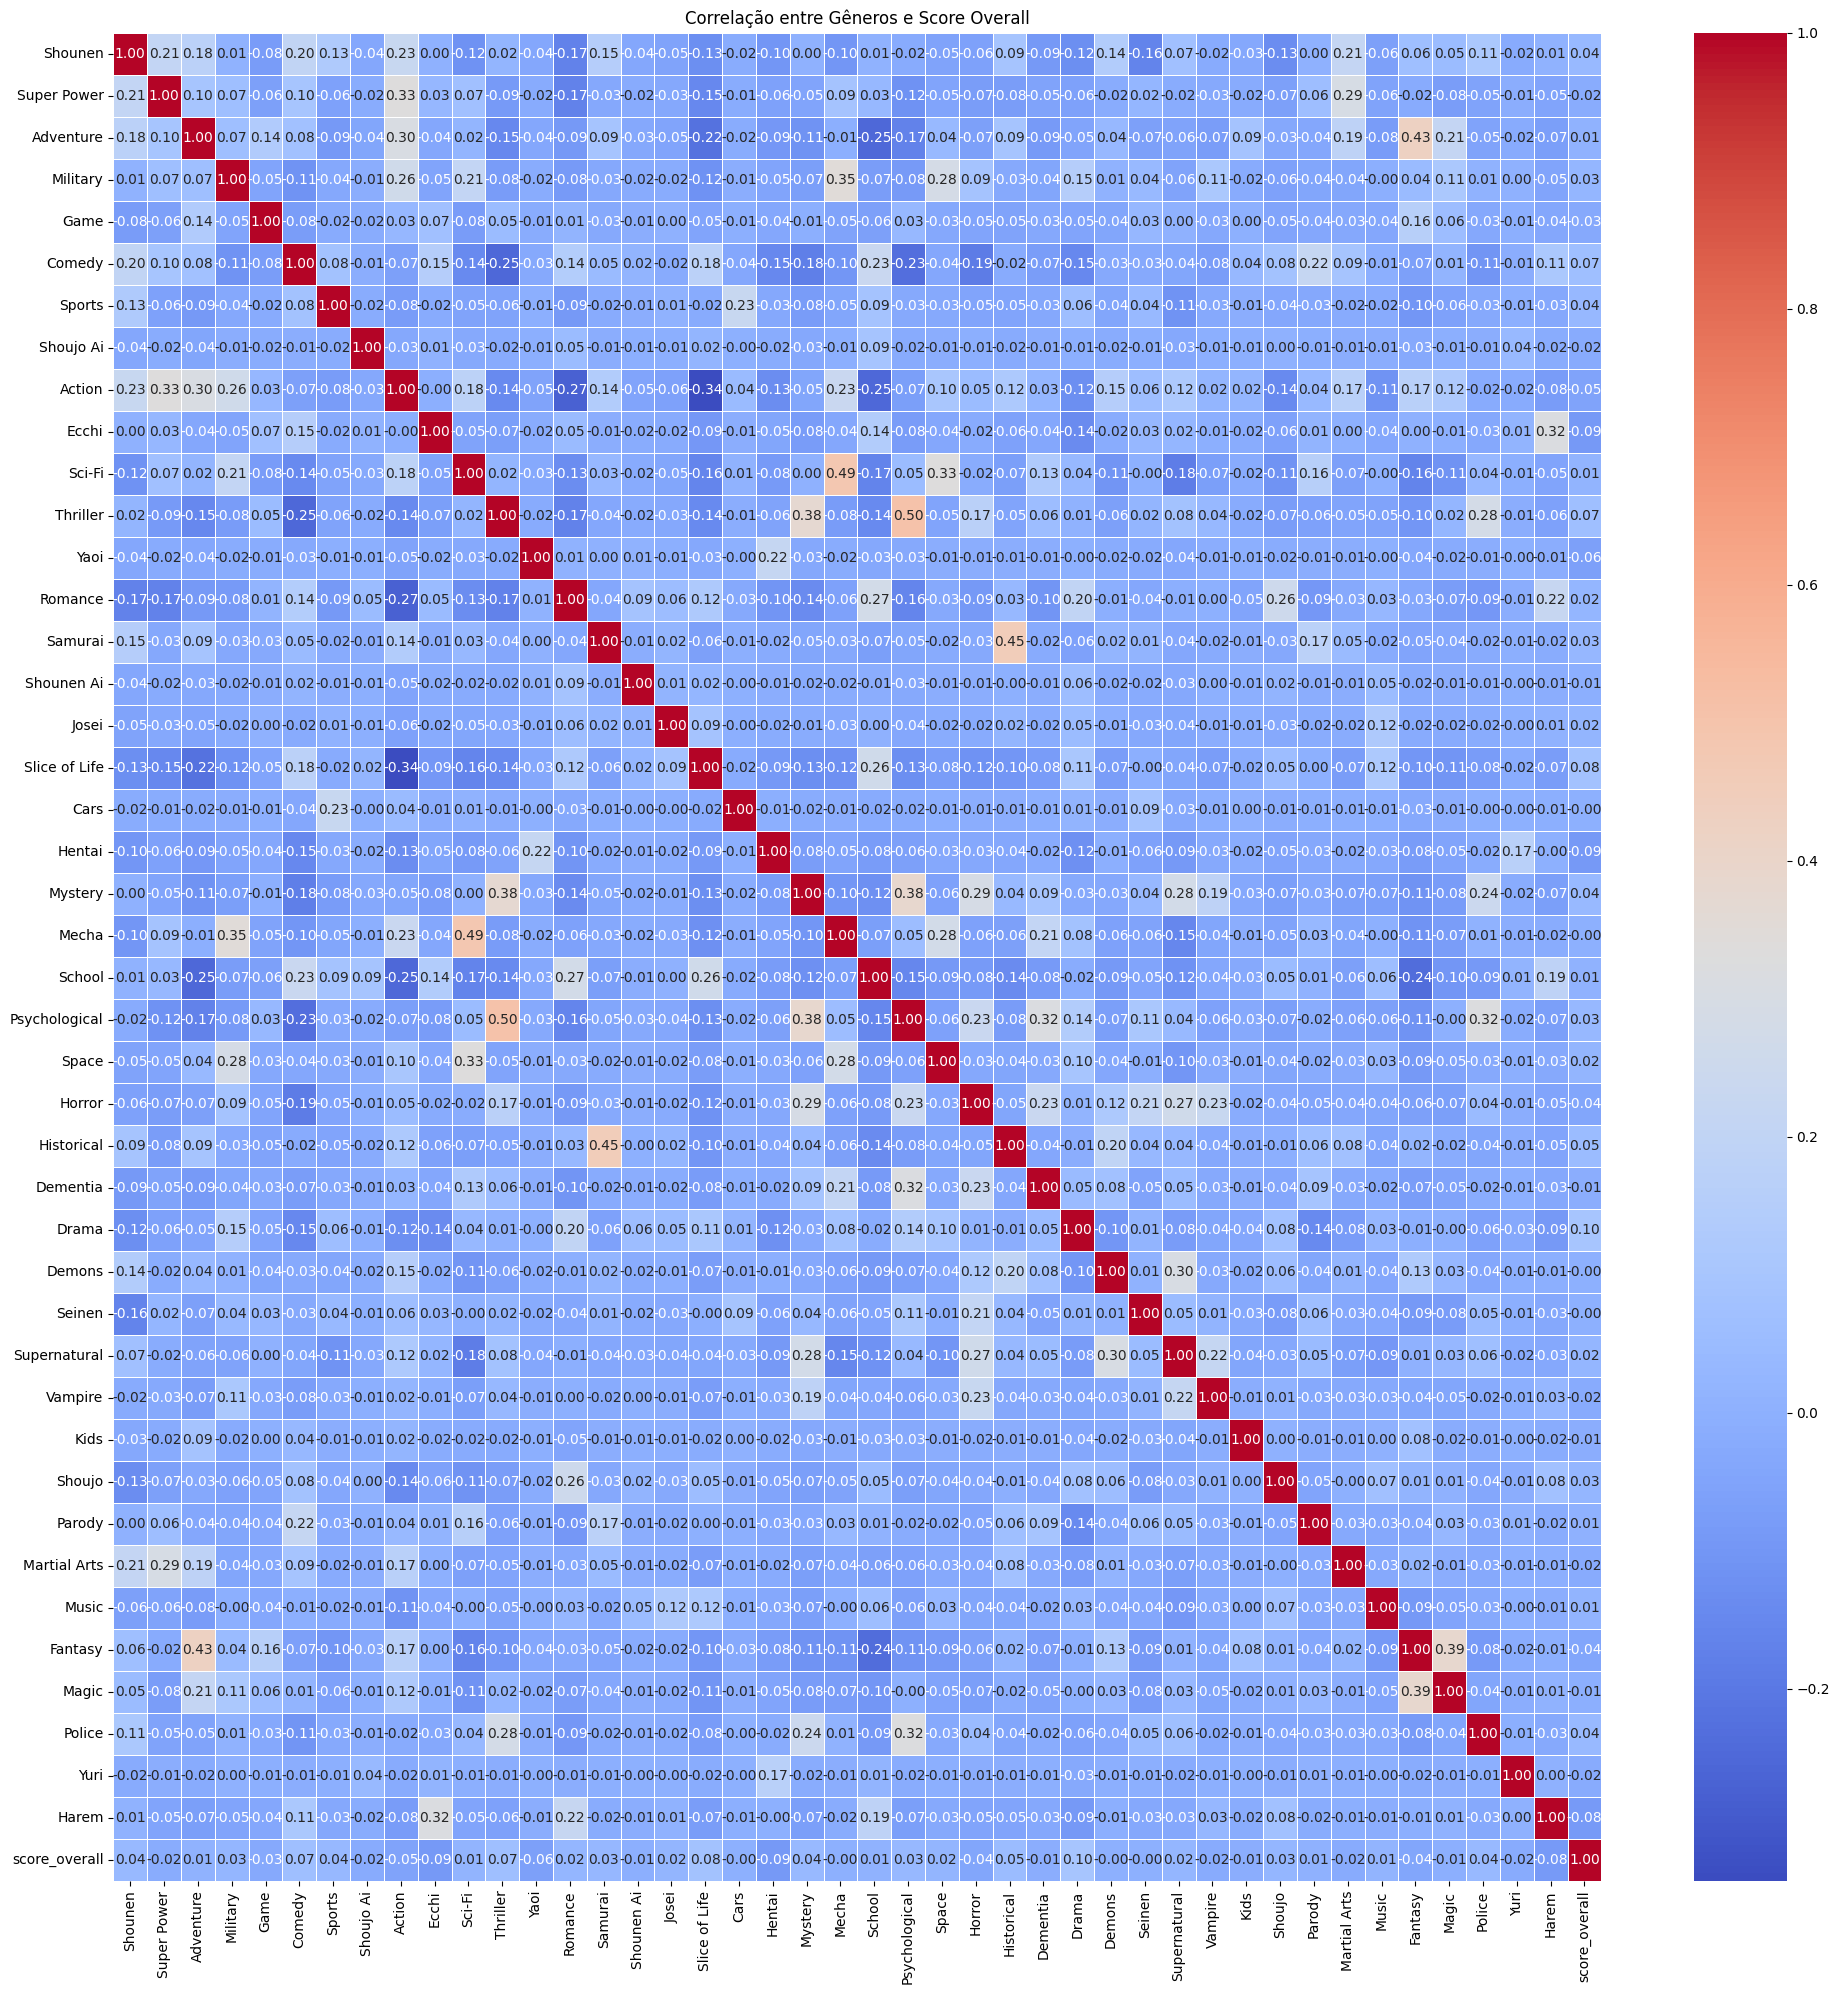

Top 10 Gêneros mais Correlacionados com 'Pontuação Geral':
Drama            0.096783
Hentai           0.092175
Ecchi            0.091181
Harem            0.082780
Slice of Life    0.080626
Comedy           0.068778
Thriller         0.066214
Yaoi             0.063217
Action           0.052657
Historical       0.048678
Name: score_overall, dtype: float64


In [16]:
# Célula 2.2(b) - Heatmap com Gêneros e Scores
# Selecionar colunas de interesse: gêneros + score_overall
columns_for_correlation = list(genre_columns) + ["score_overall"]

# Calcular correlação
correlation_genres_scores = df[columns_for_correlation].corr()

# Plotar o heatmap
plt.figure(figsize=(24, 24))
sns.heatmap(correlation_genres_scores, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlação entre Gêneros e Score Overall")
plt.show()

# Selecionar apenas correlações entre 'score_overall' e os gêneros
correlations_with_overall = correlation_genres_scores["score_overall"].drop("score_overall", errors="ignore")

# Classificar por valor absoluto (correlações positivas e negativas mais fortes)
top_10_correlations = correlations_with_overall.abs().sort_values(ascending=False).head(10)

# Imprimir o Top 10
print("Top 10 Gêneros mais Correlacionados com 'Pontuação Geral':")
print(top_10_correlations)


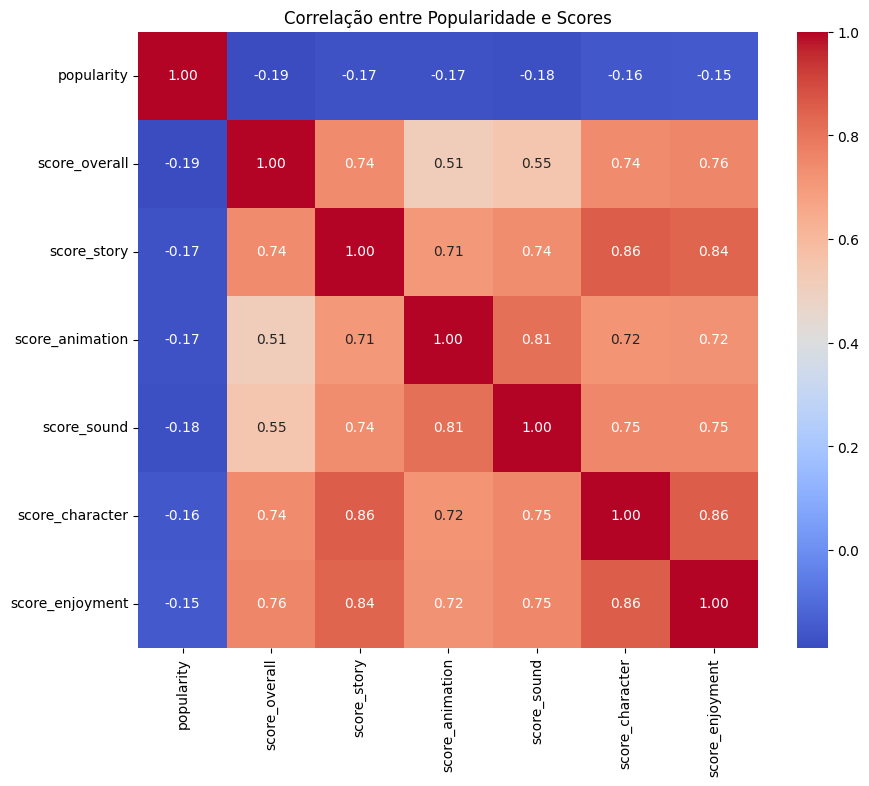

In [17]:
# Célula 2.2(c) - Análise de Popularidade
# Heatmap de Correlação entre Popularidade e Scores

# Lista de colunas numéricas principais
numeric_columns = ['score_overall', 'score_story', 'score_animation', 'score_sound', 
                   'score_character', 'score_enjoyment', 'members', 'popularity']

columns_for_correlation = ['popularity'] + [col for col in numeric_columns if 'score_' in col]
correlation_popularity = df[columns_for_correlation].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_popularity, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlação entre Popularidade e Scores")
plt.show()

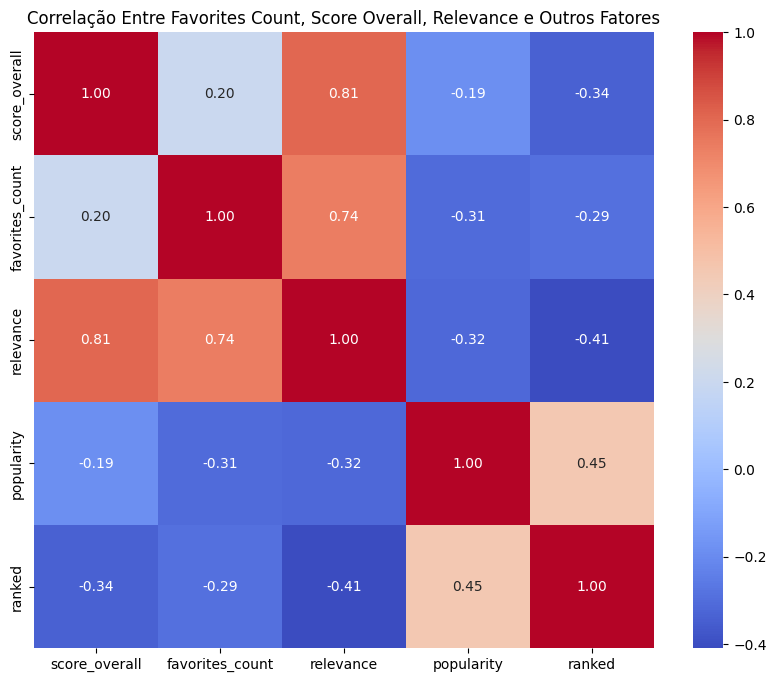

In [18]:
# Célula 2.2(d) - Heatmap de Correlação Incluindo Relevance

# Selecionar colunas relevantes
correlation_columns = ['score_overall', 'favorites_count', 'relevance', 'popularity', 'ranked']

# Calcular correlação
correlation_matrix = df[correlation_columns].corr()

# Plotar o heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlação Entre Favorites Count, Score Overall, Relevance e Outros Fatores")
plt.show()


### Faixa Dinâmica

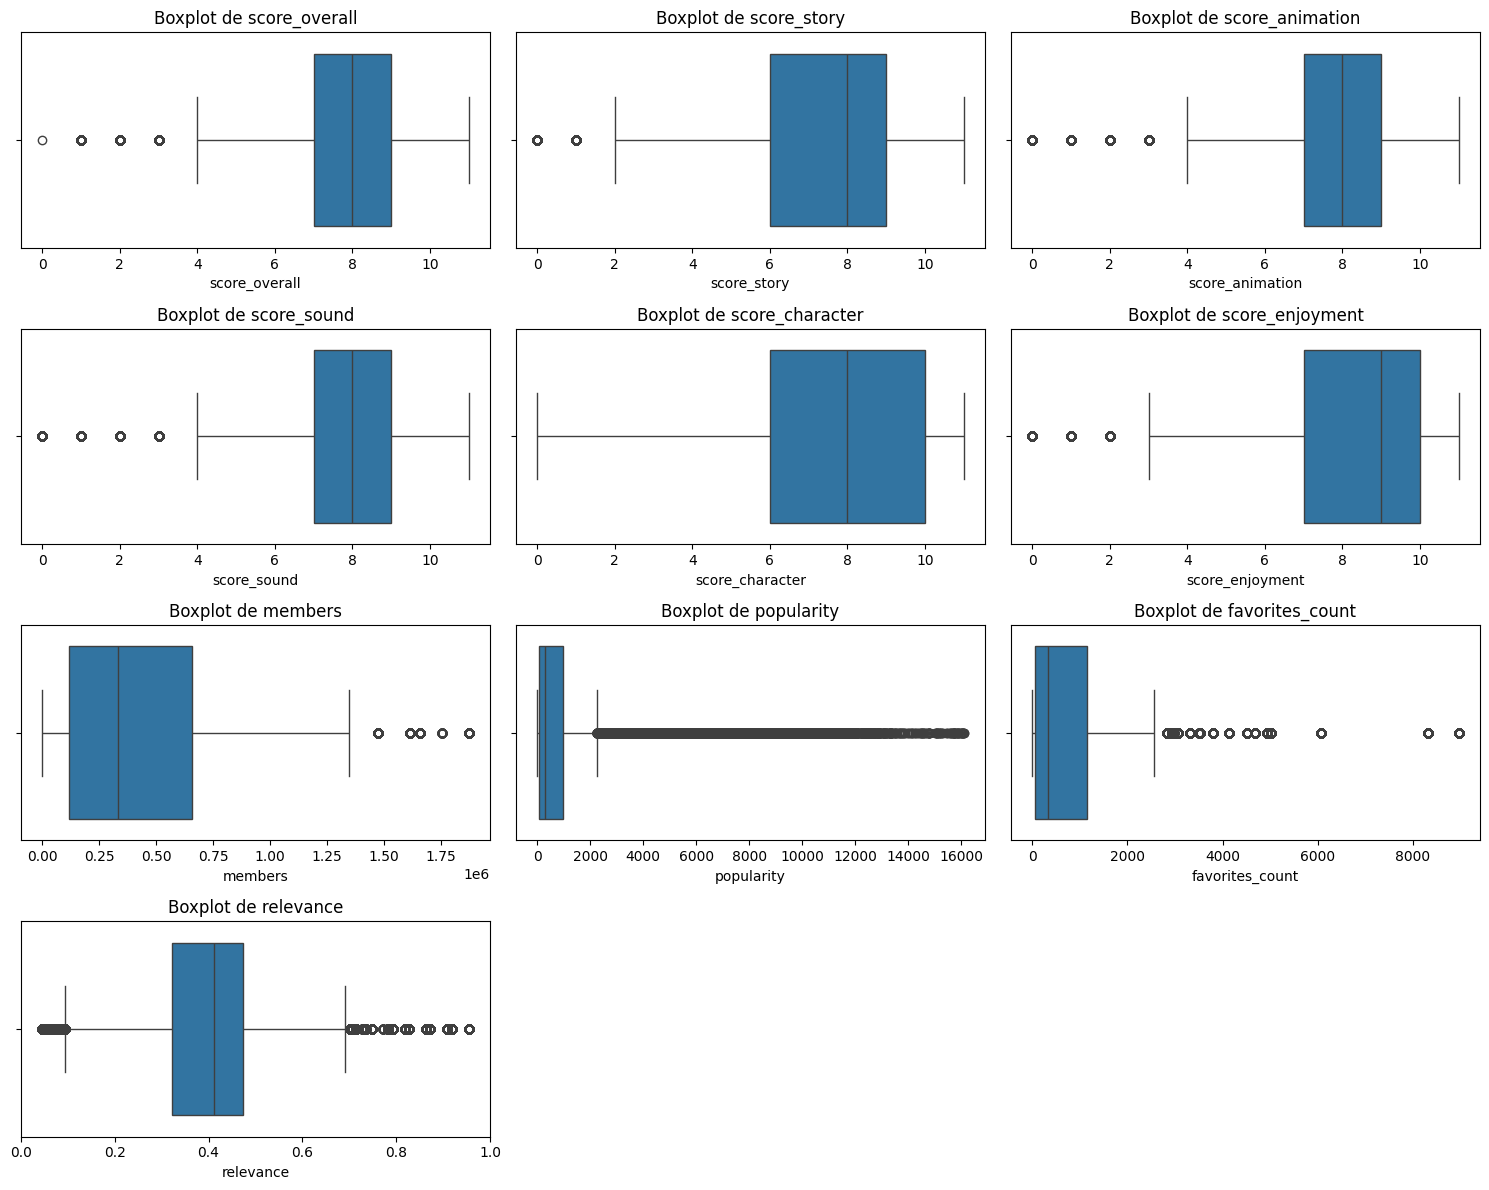

Estatísticas detalhadas para colunas numéricas:

score_overall:
count    317479.000000
mean          7.769824
std           2.177618
min           0.000000
25%           7.000000
50%           8.000000
75%           9.000000
max          11.000000
Name: score_overall, dtype: float64

score_story:
count    317479.000000
mean          7.105535
std           2.760208
min           0.000000
25%           6.000000
50%           8.000000
75%           9.000000
max          11.000000
Name: score_story, dtype: float64

score_animation:
count    317479.000000
mean          7.706831
std           2.426765
min           0.000000
25%           7.000000
50%           8.000000
75%           9.000000
max          11.000000
Name: score_animation, dtype: float64

score_sound:
count    317479.000000
mean          7.632007
std           2.467008
min           0.000000
25%           7.000000
50%           8.000000
75%           9.000000
max          11.000000
Name: score_sound, dtype: float64

score_chara

In [19]:
# Célula 2.3 - Explorar Outliers

# Lista de colunas numéricas principais (incluindo as novas)
numeric_columns = ['score_overall', 'score_story', 'score_animation', 'score_sound', 
                   'score_character', 'score_enjoyment', 'members', 'popularity',
                   'favorites_count', 'relevance']

# Boxplot para identificar outliers
plt.figure(figsize=(15, 12))
for i, col in enumerate(numeric_columns, 1):
    plt.subplot(4, 3, i)
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot de {col}")
plt.tight_layout()
plt.show()

# Estatísticas detalhadas para verificar valores extremos
print("Estatísticas detalhadas para colunas numéricas:")
for col in numeric_columns:
    print(f"\n{col}:")
    print(df[col].describe())


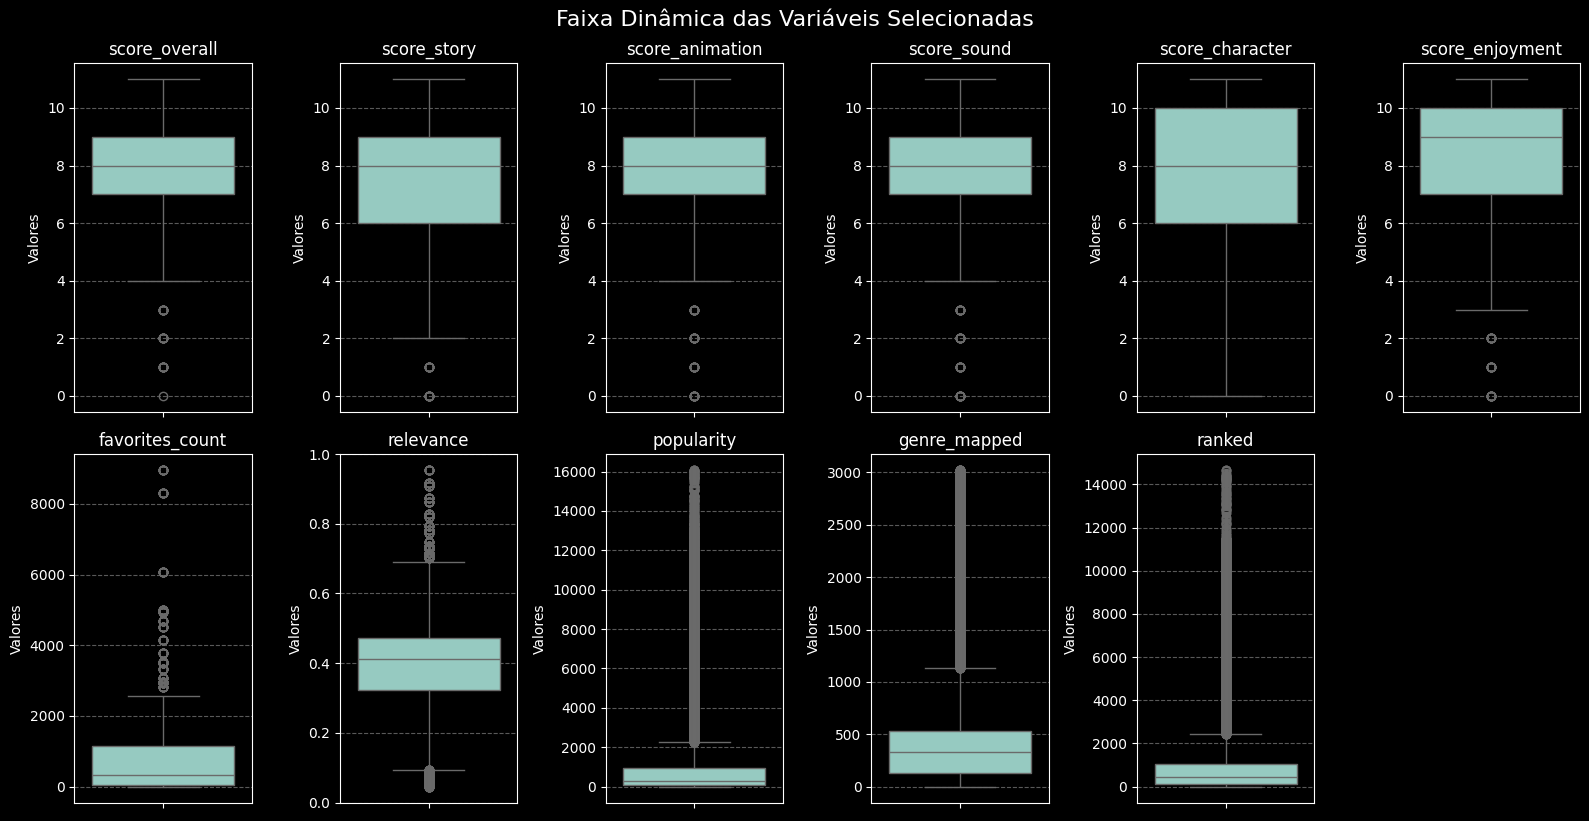

In [29]:
#Célula 2.3(b) - Faixa Dinâmica das Variáveis Selecionadas para clusterização
# Configurar o estilo para background preto
plt.style.use('dark_background')

# Selecionar as variáveis para o boxplot
variables_for_boxplot = ['score_overall', 'score_story', 'score_animation', 'score_sound', 
                         'score_character', 'score_enjoyment', 'favorites_count', 
                         'relevance', 'popularity', 'genre_mapped', 'ranked']

# Configurar o grid de plots
num_vars = len(variables_for_boxplot)
cols = 6  # Número de colunas no grid
rows = (num_vars // cols) + (num_vars % cols > 0)

fig, axes = plt.subplots(rows, cols, figsize=(16, 8), facecolor='black')
axes = axes.flatten()  # Converter para uma lista para facilitar a iteração

# Criar um boxplot para cada variável
for i, var in enumerate(variables_for_boxplot):
    sns.boxplot(data=df, y=var, ax=axes[i])
    axes[i].set_title(var, fontsize=12, color='white')
    axes[i].grid(axis='y', linestyle='--', alpha=0.7, color='gray')
    axes[i].set_xlabel("")
    axes[i].set_ylabel("Valores", fontsize=10, color='white')
    axes[i].tick_params(colors='white')  # Alterar a cor dos ticks e labels do eixo

# Remover eixos de plots vazios, se houver
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Ajustar layout
plt.tight_layout()
plt.suptitle("Faixa Dinâmica das Variáveis Selecionadas", fontsize=16, color='white', y=1.02)
plt.show()


### Verificação Manual

In [ ]:
# Célula 2.4 - Top Animes por Relevance (Agrupados por Anime)

# Agrupar por 'uid' (anime) e calcular a média de 'relevance', 'favorites_count', e 'score_overall'
top_relevance_grouped = (
    df.groupby(['uid', 'title', 'genre'], as_index=False)
    .agg({
        'relevance': 'mean',  
        'favorites_count': 'mean',  
        'score_overall': 'mean'  
    })
)

# Selecionar os 10 animes mais relevantes
top_relevance_grouped = top_relevance_grouped.nlargest(10, 'relevance')

# Exibir as informações principais
print("Top 10 Animes por Relevance (Agrupados por Anime):")
print(top_relevance_grouped[['uid', 'title', 'genre', 'relevance', 'favorites_count', 'score_overall']])


Top 10 Animes por Relevance (Agrupados por Anime):
       uid                             title  \
3104  5114  Fullmetal Alchemist: Brotherhood   
4015  9253                       Steins;Gate   
1282  1535                        Death Note   
2835  4181              Clannad: After Story   
1316  1575   Code Geass: Hangyaku no Lelouch   
1644  2001        Tengen Toppa Gurren Lagann   
0        1                      Cowboy Bebop   
11      21                         One Piece   
4117  9756        Mahou Shoujo Madoka★Magica   
20      30           Neon Genesis Evangelion   

                                                  genre  relevance  \
3104  ['Action', 'Military', 'Adventure', 'Comedy', ...   0.920151   
4015                             ['Thriller', 'Sci-Fi']   0.871569   
1282  ['Mystery', 'Police', 'Psychological', 'Supern...   0.739362   
2835  ['Slice of Life', 'Comedy', 'Supernatural', 'D...   0.697332   
1316  ['Action', 'Military', 'Sci-Fi', 'Super Power'...   0.665422   


C:\Users\saulo\AppData\Local\Temp\ipykernel_5028\3654818114.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


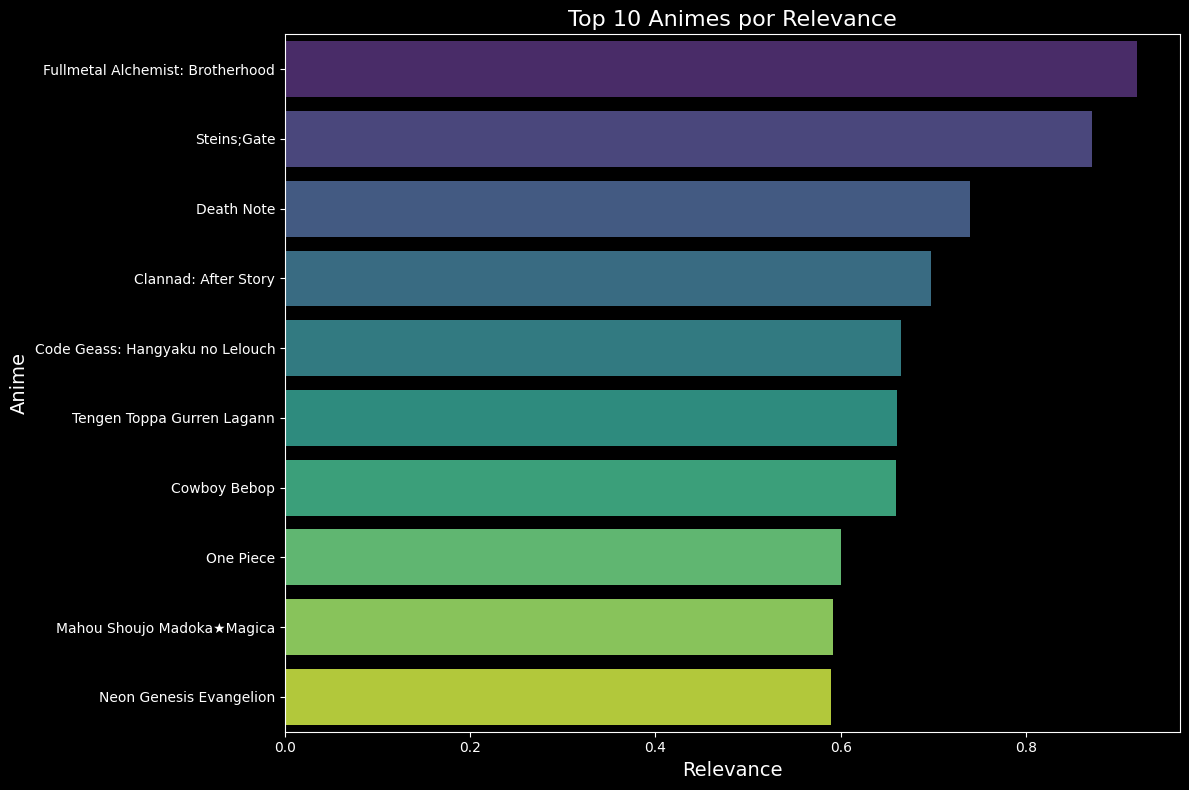

In [ ]:
# Célula 2.4(b) - Gráfico dos Top 10 Animes por Relevance

# Configurar o tamanho da figura e a cor do fundo
fig, ax = plt.subplots(figsize=(12, 8))
fig.patch.set_facecolor('black')  
ax.set_facecolor('black')       

# Plotar o gráfico de barras
sns.barplot(
    x='relevance',
    y='title',
    data=top_relevance_grouped,
    palette='viridis',
    ax=ax
)

# Adicionar título e rótulos com cores brancas para visibilidade
ax.set_title("Top 10 Animes por Relevance", fontsize=16, color='white')
ax.set_xlabel("Relevance", fontsize=14, color='white')
ax.set_ylabel("Anime", fontsize=14, color='white')

# Ajustar a cor dos ticks
ax.tick_params(colors='white')

# Ajustar layout
plt.tight_layout()
plt.show()


# Clusterização 

In [3]:
# Carregar o dataset final processado
df = pd.read_csv("data/dataset_final_processed_v2.csv")

# Gerar uma amostra aleatória
#df = df_.sample(frac=0.1, random_state=42)
print(df.shape)

(317479, 65)


In [4]:
# Selecionar colunas para clusterização
genre_columns = ['Drama', 'Yaoi', 'School', 'Demons', 'Magic', 'Horror', 'Music', 
                 'Psychological', 'Comedy', 'Shoujo Ai', 'Shounen Ai', 'Hentai', 
                 'Kids', 'Samurai', 'Game', 'Dementia', 'Yuri', 'Romance', 'Thriller', 
                 'Fantasy', 'Cars', 'Parody', 'Slice of Life', 'Historical', 'Vampire', 
                 'Adventure', 'Police', 'Shoujo', 'Harem', 'Martial Arts', 'Mystery', 
                 'Supernatural', 'Sci-Fi', 'Mecha', 'Josei', 'Ecchi', 'Sports', 
                 'Super Power', 'Seinen', 'Space', 'Shounen', 'Action', 'Military']

# Métricas numéricas e de relevância
metric_columns = ['relevance', 'favorites_count', 'popularity']

# Criar um dataframe com as colunas selecionadas
cluster_data = df[genre_columns + metric_columns]

# Normalizar os dados numéricos
scaler = MinMaxScaler()
cluster_data_scaled = scaler.fit_transform(cluster_data)

# Converter para float32
cluster_data_scaled = cluster_data_scaled.astype('float32')

print("Dados normalizados e prontos para clusterização.")


Dados normalizados e prontos para clusterização.


## K-Mean

In [5]:
# Número aproximado de clusters (K) - Raiz Quadrada Estatística
n_samples = cluster_data_scaled.shape[0]
estimated_k = int(math.sqrt(n_samples / 2))
print(f"Estimativa inicial para K (Raiz Quadrada Estatística): {estimated_k}")

Estimativa inicial para K (Raiz Quadrada Estatística): 398


In [5]:
# Célula 3 - Calcular o Melhor K
k_range = range(1550, 1801, 50) 
silhouette_scores = []

start_time = datetime.now()
print(f"{start_time.strftime('%H:%M:%S')} - Iniciando a busca pelo melhor K...")

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(cluster_data_scaled)
    silhouette_avg = silhouette_score(cluster_data_scaled, cluster_labels)
    ch_score = calinski_harabasz_score(cluster_data_scaled, cluster_labels)
    db_score = davies_bouldin_score(cluster_data_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    
    # Obter o horário atual para o print
    current_time = datetime.now().strftime("%H:%M:%S")
    print(f"{current_time} - K = {k}, Silhouette Score = {silhouette_avg:.4f}, "
          f"CH Score = {ch_score:.4f}, DB Score = {db_score:.4f}")

# Melhor K baseado no índice de silhueta
best_k = k_range[silhouette_scores.index(max(silhouette_scores))]
end_time = datetime.now().strftime("%H:%M:%S")
print(f"{end_time} - Melhor número de clusters (K) baseado na Silhueta: {best_k}")

17:00:13 - Iniciando a busca pelo melhor K...
17:41:07 - K = 1550, Silhouette Score = 0.7900, CH Score = 19353.8223, DB Score = 0.6403
18:22:39 - K = 1600, Silhouette Score = 0.7861, CH Score = 19971.4766, DB Score = 0.6367
19:04:45 - K = 1650, Silhouette Score = 0.7743, CH Score = 20668.6387, DB Score = 0.6321
19:47:32 - K = 1700, Silhouette Score = 0.7787, CH Score = 21398.9121, DB Score = 0.6115
20:30:50 - K = 1750, Silhouette Score = 0.7812, CH Score = 22095.4961, DB Score = 0.6183
21:14:35 - K = 1800, Silhouette Score = 0.7725, CH Score = 23002.2051, DB Score = 0.6041
21:14:35 - Melhor número de clusters (K) baseado na Silhueta: 1550


**400 to 1800** \
17:49:18 - K = 400, Silhouette Score = 0.6478, CH Score = 8997.2432, DB Score = 0.9652 \
18:17:57 - K = 450, Silhouette Score = 0.6767, CH Score = 9344.5771, DB Score = 0.9240 \
18:46:59 - K = 500, Silhouette Score = 0.6962, CH Score = 9638.9385, DB Score = 0.9064 \
19:16:25 - K = 550, Silhouette Score = 0.7166, CH Score = 9972.0781, DB Score = 0.8764 \
19:46:16 - K = 600, Silhouette Score = 0.7315, CH Score = 10329.8369, DB Score = 0.8510 \
20:16:30 - K = 650, Silhouette Score = 0.7446, CH Score = 10586.4482, DB Score = 0.8377 \
20:47:04 - K = 700, Silhouette Score = 0.7552, CH Score = 10901.8281, DB Score = 0.8272 \
21:18:01 - K = 750, Silhouette Score = 0.7680, CH Score = 11274.5586, DB Score = 0.8335 \
21:49:10 - K = 800, Silhouette Score = 0.7624, CH Score = 11691.2705, DB Score = 0.8013 \
08:28:40 - K = 850, Silhouette Score = 0.7707, CH Score = 12049.7344, DB Score = 0.8053 \
09:01:59 - K = 900, Silhouette Score = 0.7807, CH Score = 12534.4355, DB Score = 0.7742 \
09:35:50 - K = 950, Silhouette Score = 0.7890, CH Score = 12829.0010, DB Score = 0.7666 \
10:09:04 - K = 1000, Silhouette Score = 0.7871, CH Score = 13190.9043, DB Score = 0.7711 \
10:42:28 - K = 1050, Silhouette Score = 0.7867, CH Score = 13737.1943, DB Score = 0.7476 \
11:18:34 - K = 1100, Silhouette Score = 0.7919, CH Score = 14206.5381, DB Score = 0.7360 \
11:55:14 - K = 1150, Silhouette Score = 0.7888, CH Score = 14696.5781, DB Score = 0.7302 \
12:32:37 - K = 1200, Silhouette Score = 0.7974, CH Score = 15203.6953, DB Score = 0.7068 \
13:39:40 - K = 1250, Silhouette Score = 0.7938, CH Score = 15701.8340, DB Score = 0.6906 \
14:18:56 - K = 1300, Silhouette Score = 0.7877, CH Score = 16217.3564, DB Score = 0.6876 \
14:58:30 - K = 1350, Silhouette Score = 0.7998, CH Score = 16906.0234, DB Score = 0.6852 \
15:38:09 - K = 1400, Silhouette Score = 0.7898, CH Score = 17432.8848, DB Score = 0.6690 \
16:17:59 - K = 1450, Silhouette Score = 0.7940, CH Score = 18016.9297, DB Score = 0.6656 \
16:58:24 - K = 1500, Silhouette Score = 0.7958, CH Score = 18665.9141, DB Score = 0.6551 \
17:41:07 - K = 1550, Silhouette Score = 0.7900, CH Score = 19353.8223, DB Score = 0.6403 \
18:22:39 - K = 1600, Silhouette Score = 0.7861, CH Score = 19971.4766, DB Score = 0.6367 \
19:04:45 - K = 1650, Silhouette Score = 0.7743, CH Score = 20668.6387, DB Score = 0.6321 \
19:47:32 - K = 1700, Silhouette Score = 0.7787, CH Score = 21398.9121, DB Score = 0.6115 \
20:30:50 - K = 1750, Silhouette Score = 0.7812, CH Score = 22095.4961, DB Score = 0.6183 \
21:14:35 - K = 1800, Silhouette Score = 0.7725, CH Score = 23002.2051, DB Score = 0.6041


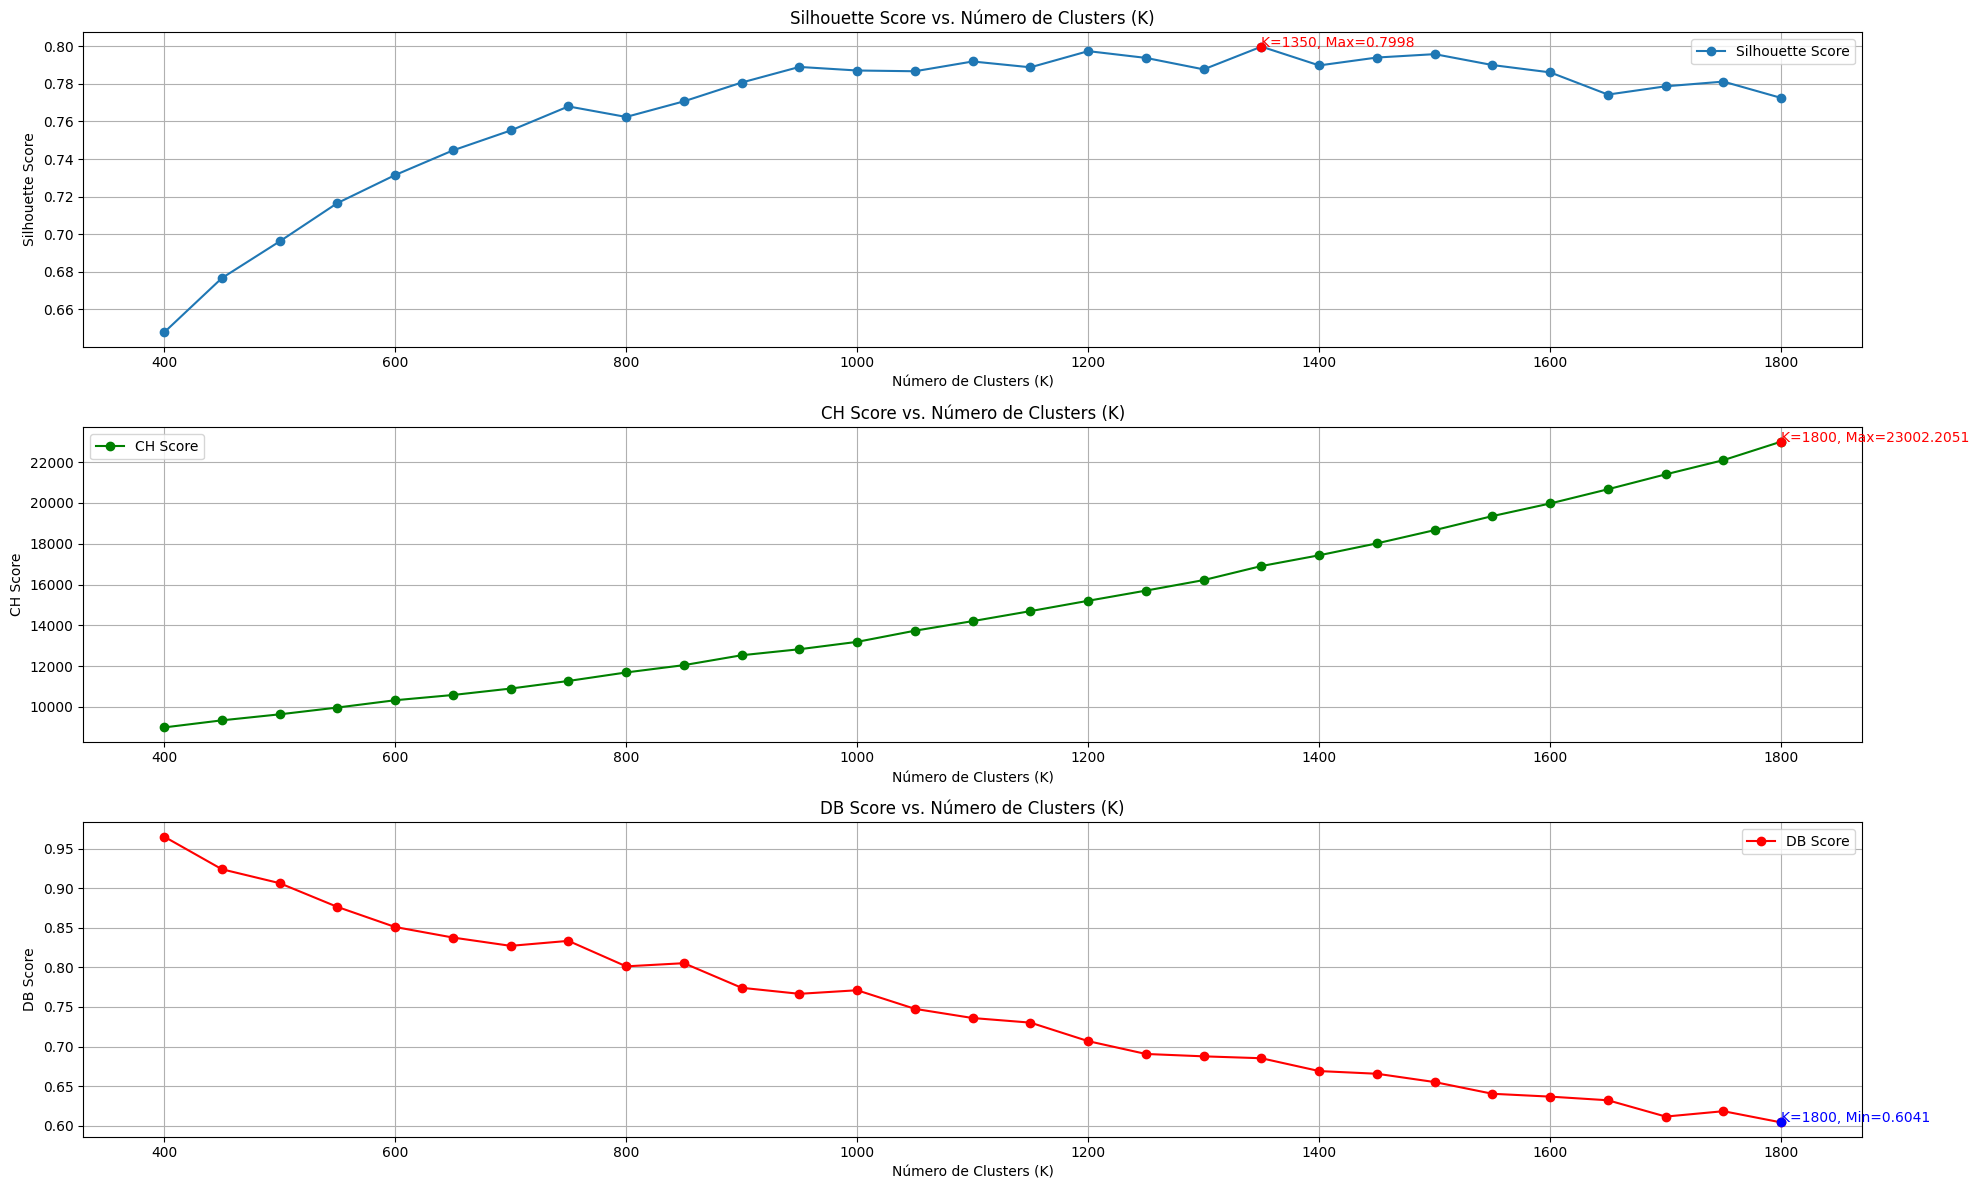

In [ ]:
# Célula 3.1 - Plotar o Resultado da Busca pelo Melhor K
# Caminho do arquivo
file_path = f"{data_dir}/kmean_result.txt"

# Listas para armazenar os dados
timestamps, k_values, silhouette_scores, ch_scores, db_scores = [], [], [], [], []

# Ler o arquivo e processar as linhas
with open(file_path, 'r') as file:
    for line in file:
        # Usar regex para extrair os valores
        match = re.search(r"(\d{2}:\d{2}:\d{2}) - K = (\d+), Silhouette Score = ([\d.]+), CH Score = ([\d.]+), DB Score = ([\d.]+)", line)
        if match:
            timestamps.append(match.group(1))
            k_values.append(int(match.group(2)))
            silhouette_scores.append(float(match.group(3)))
            ch_scores.append(float(match.group(4)))
            db_scores.append(float(match.group(5)))

# Criar um DataFrame
df_metrics = pd.DataFrame({
    'Timestamp': timestamps,
    'K': k_values,
    'Silhouette Score': silhouette_scores,
    'CH Score': ch_scores,
    'DB Score': db_scores
})

# Identificar os melhores pontos
best_silhouette_idx = df_metrics['Silhouette Score'].idxmax()
best_ch_idx = df_metrics['CH Score'].idxmax()
best_db_idx = df_metrics['DB Score'].idxmin()

best_silhouette_k = df_metrics.loc[best_silhouette_idx, 'K']
best_ch_k = df_metrics.loc[best_ch_idx, 'K']
best_db_k = df_metrics.loc[best_db_idx, 'K']

# Plotar os gráficos
plt.figure(figsize=(20, 12))

# Silhouette Score
plt.subplot(3, 1, 1)
plt.plot(df_metrics['K'], df_metrics['Silhouette Score'], marker='o', label='Silhouette Score')
plt.scatter(best_silhouette_k, df_metrics.loc[best_silhouette_idx, 'Silhouette Score'], color='red', zorder=5)
plt.text(best_silhouette_k, df_metrics.loc[best_silhouette_idx, 'Silhouette Score'], 
         f"K={best_silhouette_k}, Max={df_metrics.loc[best_silhouette_idx, 'Silhouette Score']:.4f}", 
         color='red', fontsize=10)
plt.title("Silhouette Score vs. Número de Clusters (K)")
plt.xlabel("Número de Clusters (K)")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.legend()

# CH Score
plt.subplot(3, 1, 2)
plt.plot(df_metrics['K'], df_metrics['CH Score'], marker='o', color='green', label='CH Score')
plt.scatter(best_ch_k, df_metrics.loc[best_ch_idx, 'CH Score'], color='red', zorder=5)
plt.text(best_ch_k, df_metrics.loc[best_ch_idx, 'CH Score'], 
         f"K={best_ch_k}, Max={df_metrics.loc[best_ch_idx, 'CH Score']:.4f}", 
         color='red', fontsize=10)
plt.title("CH Score vs. Número de Clusters (K)")
plt.xlabel("Número de Clusters (K)")
plt.ylabel("CH Score")
plt.grid(True)
plt.legend()

# DB Score
plt.subplot(3, 1, 3)
plt.plot(df_metrics['K'], df_metrics['DB Score'], marker='o', color='red', label='DB Score')
plt.scatter(best_db_k, df_metrics.loc[best_db_idx, 'DB Score'], color='blue', zorder=5)
plt.text(best_db_k, df_metrics.loc[best_db_idx, 'DB Score'], 
         f"K={best_db_k}, Min={df_metrics.loc[best_db_idx, 'DB Score']:.4f}", 
         color='blue', fontsize=10)
plt.title("DB Score vs. Número de Clusters (K)")
plt.xlabel("Número de Clusters (K)")
plt.ylabel("DB Score")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


In [7]:
# Célula 3.2 - Aplicar K-Means com o Melhor K e Avaliar Métricas
best_k = 1350  

# Ajustar o K-Means com o melhor K
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
df['kmeans_cluster'] = kmeans.fit_predict(cluster_data_scaled)

# Calcular as métricas de validação
silhouette_avg = silhouette_score(cluster_data_scaled, df['kmeans_cluster'])
ch_score = calinski_harabasz_score(cluster_data_scaled, df['kmeans_cluster'])
db_score = davies_bouldin_score(cluster_data_scaled, df['kmeans_cluster'])

# Exibir os resultados das métricas
print(f"Métricas de Validação para K-Means com K = {best_k}:")
print(f"- Índice de Silhueta: {silhouette_avg:.4f}")
print(f"- Índice de Calinski-Harabasz: {ch_score:.4f}")
print(f"- Índice de Davies-Bouldin: {db_score:.4f}")

# Salvar os dados com os clusters atribuídos
kmeans_output_path = os.path.join(data_dir, "dataset_with_kmeans_clusters_v2.csv") 
df.to_csv(kmeans_output_path, index=False)

# Exibir a distribuição dos clusters
print(f"\nK-Means aplicado e clusters salvos em: {kmeans_output_path}\n")
print("Distribuição dos clusters:")
print(df['kmeans_cluster'].value_counts())

Métricas de Validação para K-Means com K = 1350:
- Índice de Silhueta: 0.7998
- Índice de Calinski-Harabasz: 16906.0234
- Índice de Davies-Bouldin: 0.6852

K-Means aplicado e clusters salvos em: C:/ML/Anime/data\dataset_with_kmeans_clusters_v2.csv

Distribuição dos clusters:
kmeans_cluster
22      3416
42      3351
33      3116
28      2889
1       2597
        ... 
1261       8
240        8
964        7
1141       6
1218       5
Name: count, Length: 1350, dtype: int64


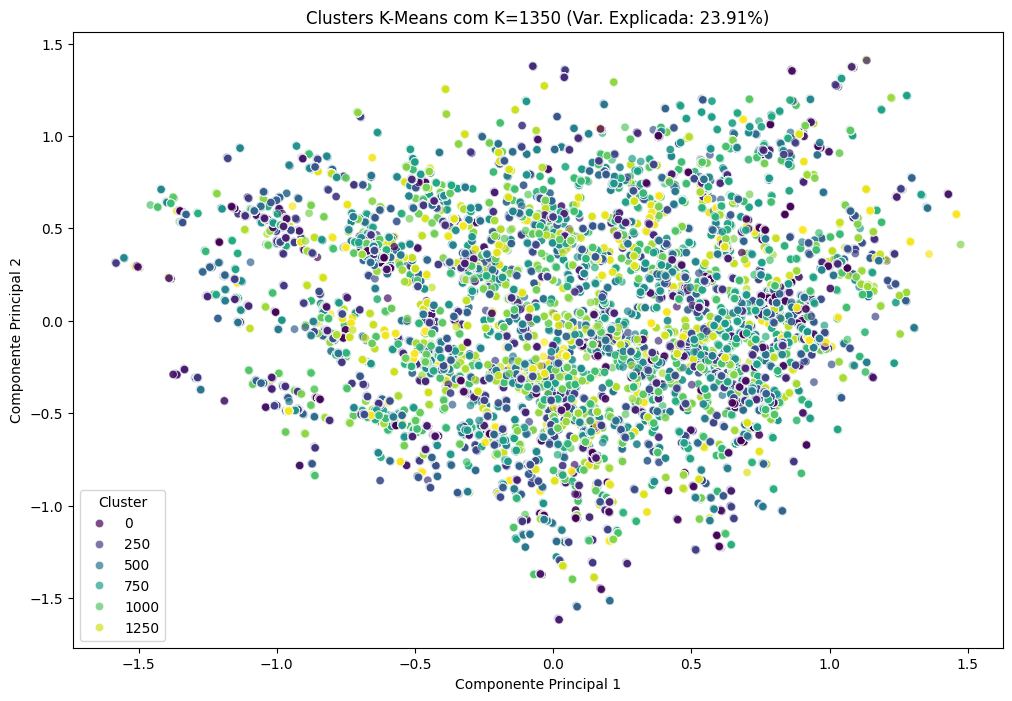

In [ ]:
# Célula 3.3 - Visualização dos Clusters com PCA em 2D
pca = PCA(n_components=2)
pca_result = pca.fit_transform(cluster_data_scaled)

# Adicionar componentes principais ao dataframe
df['pca_1'] = pca_result[:, 0]
df['pca_2'] = pca_result[:, 1]

# Percentual de variação explicada
explained_variance = pca.explained_variance_ratio_.sum() * 100

# Plotar os clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(x='pca_1', y='pca_2', hue=df['kmeans_cluster'], data=df, palette="viridis", alpha=0.7)
plt.title(f"Clusters K-Means com K={best_k} (Var. Explicada: {explained_variance:.2f}%)")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.legend(title="Cluster")
plt.show()

In [ ]:
# Célula 3.3(b) - Visualização Interativa em 3D 
# Reduzir a dimensionalidade para 3 componentes principais
pca_3d = PCA(n_components=3)
pca_result_3d = pca_3d.fit_transform(cluster_data_scaled)

# Criar um dataframe temporário para o gráfico interativo
df_pca_3d = pd.DataFrame({
    'PCA1': pca_result_3d[:, 0],
    'PCA2': pca_result_3d[:, 1],
    'PCA3': pca_result_3d[:, 2],
    'Cluster': df['kmeans_cluster']
})

# Criar o gráfico interativo
fig = px.scatter_3d(df_pca_3d, x='PCA1', y='PCA2', z='PCA3',
                    color='Cluster', color_continuous_scale='Viridis',
                    title=f"Clusters K-Means com K={best_k} (Projeção 3D via PCA)",
                    labels={'Cluster': 'Cluster'})

# Melhorar o layout
fig.update_traces(marker=dict(size=5, opacity=0.7))
fig.update_layout(scene=dict(
    xaxis_title="Componente Principal 1",
    yaxis_title="Componente Principal 2",
    zaxis_title="Componente Principal 3"
),height=800  
)

# Exibir o gráfico
fig.show()

## DBScan

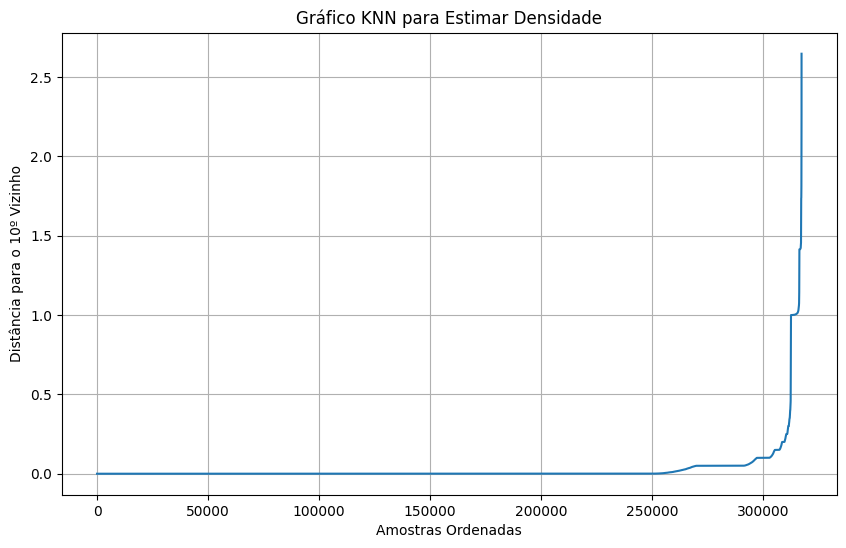

In [6]:
# Método Elbow
# Calcular as distâncias para os k vizinhos mais próximos
knn = NearestNeighbors(n_neighbors=10)
knn_fit = knn.fit(cluster_data_scaled)
distances, indices = knn_fit.kneighbors(cluster_data_scaled)

# Ordenar as distâncias dos k-vizinhos
sorted_distances = np.sort(distances[:, 9])  

# Plotar o gráfico KNN
plt.figure(figsize=(10, 6))
plt.plot(sorted_distances)
plt.title("Gráfico KNN para Estimar Densidade")
plt.xlabel("Amostras Ordenadas")
plt.ylabel("Distância para o 10º Vizinho")
plt.grid()
plt.show()

**euclidean**: Dados escalonados linearmente com distâncias "naturais". \
**manhattan**: Dados onde o movimento entre dimensões é discreto (ex.: rotas em uma grade, dados categóricos codificados). \
**cosine**: Dados vetoriais onde a direção é mais relevante que a magnitude (ex.: textos representados por embeddings ou vetores TF-IDF). \
**minkowski**: Ajusta entre euclidean e manhattan ou outras generalizações.

min_samples = 3, eps = 0.2000, Clusters = 2575, Outliers = 1369
min_samples = 4, eps = 0.2000, Clusters = 2381, Outliers = 1977
min_samples = 5, eps = 0.2000, Clusters = 2172, Outliers = 2846
min_samples = 6, eps = 0.2000, Clusters = 2041, Outliers = 3567
min_samples = 7, eps = 0.2000, Clusters = 1949, Outliers = 4174
min_samples = 8, eps = 0.2000, Clusters = 1866, Outliers = 4811
min_samples = 9, eps = 0.2000, Clusters = 1751, Outliers = 5795
min_samples = 10, eps = 0.2000, Clusters = 1690, Outliers = 6392
min_samples = 11, eps = 0.2000, Clusters = 1643, Outliers = 6942
min_samples = 12, eps = 0.2000, Clusters = 1593, Outliers = 7550
min_samples = 13, eps = 0.2000, Clusters = 1511, Outliers = 8605
min_samples = 14, eps = 0.2000, Clusters = 1479, Outliers = 9071
min_samples = 15, eps = 0.2000, Clusters = 1444, Outliers = 9613
min_samples = 16, eps = 0.2000, Clusters = 1410, Outliers = 10211
min_samples = 17, eps = 0.2000, Clusters = 1363, Outliers = 11041
min_samples = 18, eps = 0.2000

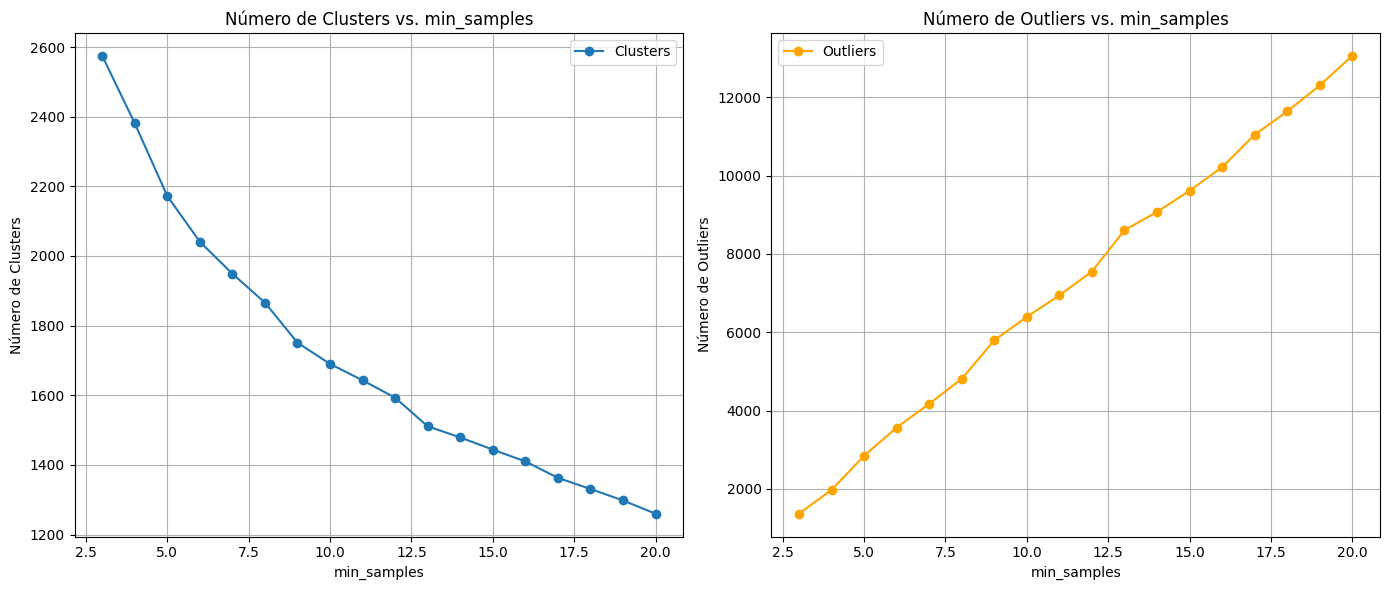

In [ ]:
# Célula 4 - Identificar min_samples e eps para DBScan TEST
# Intervalos para min_samples e inicialização de resultados
min_samples_range = range(3, 21)
results = []

for min_samples in min_samples_range:
    # Calcular as distâncias dos vizinhos mais próximos (k-dist plot)
    #neighbors = NearestNeighbors(n_neighbors=min_samples).fit(cluster_data_scaled)
    #distances, _ = neighbors.kneighbors(cluster_data_scaled)
    
    # Ordenar as distâncias e calcular o ponto sugerido para eps
    #distances = np.sort(distances[:, -1])
    #suggested_eps = distances[int(len(distances) * 0.95)]  
    suggested_eps = 0.2
    
    # Aplicar DBScan com os parâmetros atuais
    dbscan = DBSCAN(eps=suggested_eps, min_samples=min_samples)
    labels = dbscan.fit_predict(cluster_data_scaled)
    
    # Contar clusters e outliers
    num_outliers = (labels == -1).sum()
    num_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    
    # Salvar os resultados
    results.append((min_samples, suggested_eps, num_clusters, num_outliers))
    print(f"min_samples = {min_samples}, eps = {suggested_eps:.4f}, Clusters = {num_clusters}, Outliers = {num_outliers}")

# Plotar os resultados
min_samples_vals, eps_vals, clusters_vals, outliers_vals = zip(*results)

plt.figure(figsize=(14, 6))

# Gráfico de Clusters vs. min_samples
plt.subplot(1, 2, 1)
plt.plot(min_samples_vals, clusters_vals, marker='o', label='Clusters')
plt.title("Número de Clusters vs. min_samples")
plt.xlabel("min_samples")
plt.ylabel("Número de Clusters")
plt.grid()
plt.legend()

# Gráfico de Outliers vs. min_samples
plt.subplot(1, 2, 2)
plt.plot(min_samples_vals, outliers_vals, marker='o', label='Outliers', color='orange')
plt.title("Número de Outliers vs. min_samples")
plt.xlabel("min_samples")
plt.ylabel("Número de Outliers")
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

**Esp Fixo a 2.0(Elbow)**  \
min_samples = 3, eps = 0.2000, Clusters = 2575, Outliers = 1369 \
min_samples = 4, eps = 0.2000, Clusters = 2381, Outliers = 1977 \
min_samples = 5, eps = 0.2000, Clusters = 2172, Outliers = 2846 \
min_samples = 6, eps = 0.2000, Clusters = 2041, Outliers = 3567 \
min_samples = 7, eps = 0.2000, Clusters = 1949, Outliers = 4174 \
min_samples = 8, eps = 0.2000, Clusters = 1866, Outliers = 4811 \
min_samples = 9, eps = 0.2000, Clusters = 1751, Outliers = 5795 \
min_samples = 10, eps = 0.2000, Clusters = 1690, Outliers = 6392 \
min_samples = 11, eps = 0.2000, Clusters = 1643, Outliers = 6942 \
min_samples = 12, eps = 0.2000, Clusters = 1593, Outliers = 7550 \
min_samples = 13, eps = 0.2000, Clusters = 1511, Outliers = 8605 \
min_samples = 14, eps = 0.2000, Clusters = 1479, Outliers = 9071 \
min_samples = 15, eps = 0.2000, Clusters = 1444, Outliers = 9613 \
min_samples = 16, eps = 0.2000, Clusters = 1410, Outliers = 10211 \
min_samples = 17, eps = 0.2000, Clusters = 1363, Outliers = 11041 \
min_samples = 18, eps = 0.2000, Clusters = 1331, Outliers = 11636 \
min_samples = 19, eps = 0.2000, Clusters = 1298, Outliers = 12299 \
min_samples = 20, eps = 0.2000, Clusters = 1260, Outliers = 13057

**Resultado Dinâmico** \
min_samples = 3, eps = 0.0144, Clusters = 13271, Outliers = 15795 \
min_samples = 4, eps = 0.0500, Clusters = 7080, Outliers = 13106 \
min_samples = 5, eps = 0.0500, Clusters = 3082, Outliers = 12017 \
min_samples = 6, eps = 0.0508, Clusters = 2420, Outliers = 12712 \
min_samples = 7, eps = 0.0653, Clusters = 2167, Outliers = 12480 \
min_samples = 8, eps = 0.0938, Clusters = 1928, Outliers = 12319 \
min_samples = 9, eps = 0.1000, Clusters = 1740, Outliers = 11443 \
min_samples = 10, eps = 0.1000, Clusters = 1702, Outliers = 10735 \
min_samples = 11, eps = 0.1000, Clusters = 1650, Outliers = 11500 \
min_samples = 12, eps = 0.1092, Clusters = 1595, Outliers = 11557 \
min_samples = 13, eps = 0.1500, Clusters = 1451, Outliers = 11654 \
min_samples = 14, eps = 0.1500, Clusters = 1458, Outliers = 10894 \
min_samples = 15, eps = 0.1500, Clusters = 1422, Outliers = 11514 \
min_samples = 16, eps = 0.1501, Clusters = 1400, Outliers = 11692 \
min_samples = 17, eps = 0.1777, Clusters = 1355, Outliers = 11658 \
min_samples = 18, eps = 0.2000, Clusters = 1330, Outliers = 11655 \
min_samples = 19, eps = 0.2000, Clusters = 1318, Outliers = 11800 \
min_samples = 20, eps = 0.2004, Clusters = 1298, Outliers = 12129 

In [8]:
# Célula 4(a) - Atribuir Parâmetros com Base nos Resultados
# Atribuir parâmetros com base nos resultados
chosen_min_samples = 8
chosen_eps = [r[1] for r in results if r[0] == chosen_min_samples][0]

print(f"Parâmetros escolhidos: min_samples={chosen_min_samples}, eps={chosen_eps:.4f}")

Parâmetros escolhidos: min_samples=8, eps=0.2000


In [9]:
# Célula 4.1 - Aplicar o DBScan e Avaliar Métricas
# Aplicar o DBScan com os parâmetros escolhidos
dbscan = DBSCAN(eps=chosen_eps, min_samples=chosen_min_samples)#, metric=db_metric)
df['dbscan_cluster'] = dbscan.fit_predict(cluster_data_scaled)

# Filtrar para clusters válidos (excluindo os rótulos de outliers, que são -1)
valid_clusters = df['dbscan_cluster'] != -1
cluster_data_valid = cluster_data_scaled[valid_clusters]
valid_labels = df.loc[valid_clusters, 'dbscan_cluster']

# Calcular métricas de validação apenas para clusters válidos
if len(set(valid_labels)) > 1: 
    silhouette_avg = silhouette_score(cluster_data_valid, valid_labels)
    ch_score = calinski_harabasz_score(cluster_data_valid, valid_labels)
    db_score = davies_bouldin_score(cluster_data_valid, valid_labels)

    # Exibir os resultados das métricas
    print(f"Métricas de Validação para DBScan com eps = {chosen_eps}, min_samples = {chosen_min_samples}:")
    print(f"- Índice de Silhueta: {silhouette_avg:.4f}")
    print(f"- Índice de Calinski-Harabasz: {ch_score:.4f}")
    print(f"- Índice de Davies-Bouldin: {db_score:.4f}\n")
else:
    print("Não há clusters suficientes para calcular as métricas de validação.")

# Salvar os dados com os clusters atribuídos
dbscan_output_path = os.path.join(data_dir, "dataset_with_dbscan_clusters_v2.csv")  
df.to_csv(dbscan_output_path, index=False)

# Analisar a distribuição dos clusters
print(f"DBScan aplicado e clusters salvos em: {dbscan_output_path}\n")
print("Distribuição dos clusters:")
print(df['dbscan_cluster'].value_counts())


Métricas de Validação para DBScan com eps = 0.2, min_samples = 8:
- Índice de Silhueta: 0.8682
- Índice de Calinski-Harabasz: 48044.7921
- Índice de Davies-Bouldin: 0.2034

DBScan aplicado e clusters salvos em: C:/ML/Anime/data\dataset_with_dbscan_clusters_v2.csv

Distribuição dos clusters:
dbscan_cluster
 687     6947
-1       4811
 439     3416
 248     3351
 456     3116
         ... 
 735        8
 131        8
 928        8
 1847       8
 1857       8
Name: count, Length: 1867, dtype: int64


In [ ]:
# Célula 4.2 - Visualização dos Clusters DBScan em 3D com Plotly
# Reduzir a dimensionalidade para 3 componentes principais
pca = PCA(n_components=3)
pca_result_3d = pca.fit_transform(cluster_data_scaled)

# Criar um dataframe temporário para o gráfico interativo
df_dbscan_3d = pd.DataFrame({
    'PCA1': pca_result_3d[:, 0],
    'PCA2': pca_result_3d[:, 1],
    'PCA3': pca_result_3d[:, 2],
    'Cluster': df['dbscan_cluster']
})

# Criar o gráfico interativo
fig = px.scatter_3d(df_dbscan_3d, x='PCA1', y='PCA2', z='PCA3',
                    color='Cluster', color_continuous_scale='Viridis',
                    title=f"Clusters DBScan com eps={chosen_eps:.4f}, min_samples={chosen_min_samples}",
                    labels={'Cluster': 'Cluster'})

# Melhorar o layout
fig.update_traces(marker=dict(size=5, opacity=0.7))
fig.update_layout(
    scene=dict(
        xaxis_title="Componente Principal 1",
        yaxis_title="Componente Principal 2",
        zaxis_title="Componente Principal 3"
    ),
    height=800
)

# Exibir o gráfico
fig.show()

# Inferência

In [ ]:
df_dbscan = pd.read_csv(f"{data_dir}/dataset_with_dbscan_clusters_v2.csv")
df_dbscan.head().T

,0,1,2,3,4
uid,28891,28891,28891,28891,28891
title,Haikyuu!! Second Season,Haikyuu!! Second Season,Haikyuu!! Second Season,Haikyuu!! Second Season,Haikyuu!! Second Season
synopsis,Following their participation at the Inter-Hig...,Following their participation at the Inter-Hig...,Following their participation at the Inter-Hig...,Following their participation at the Inter-Hig...,Following their participation at the Inter-Hig...
genre,"['Comedy', 'Sports', 'Drama', 'School', 'Shoun...","['Comedy', 'Sports', 'Drama', 'School', 'Shoun...","['Comedy', 'Sports', 'Drama', 'School', 'Shoun...","['Comedy', 'Sports', 'Drama', 'School', 'Shoun...","['Comedy', 'Sports', 'Drama', 'School', 'Shoun..."
episodes,25.0,25.0,25.0,25.0,25.0
...,...,...,...,...,...
score_enjoyment,8,10,10,6,9
favorites_count_norm,0.057216,0.057216,0.057216,0.057216,0.057216
score_overall_norm,0.636364,0.909091,0.909091,0.636364,0.727273
relevance,0.34679,0.483154,0.483154,0.34679,0.392244


In [ ]:
db_cluster = 0
df_dbscan_filtered = df_dbscan[df_dbscan['dbscan_cluster'] == db_cluster]
print(df_dbscan_filtered[['title']].head(20))

In [24]:
# Define the word to filter by
word_to_filter = "Shingeki no Kyojin"

# Filter the dataframe
filtered_df_animes = df_dbscan[df_dbscan['title'].str.contains(word_to_filter, case=False, na=False)]

# Display the filtered dataframe
print(filtered_df_animes[['title', 'dbscan_cluster']])

                                               title  dbscan_cluster
9706                          Shingeki no Kyojin OVA              56
9707                          Shingeki no Kyojin OVA              56
9708                          Shingeki no Kyojin OVA              56
9709                          Shingeki no Kyojin OVA              56
9710                          Shingeki no Kyojin OVA              56
...                                              ...             ...
307006                Shingeki no Kyojin: Lost Girls             469
307007                Shingeki no Kyojin: Lost Girls             469
307008                Shingeki no Kyojin: Lost Girls             469
314929  Shingeki no Kyojin Movie 2: Jiyuu no Tsubasa              56
314930  Shingeki no Kyojin Movie 2: Jiyuu no Tsubasa              56

[450 rows x 2 columns]


In [26]:
filtered_df_animes[['title', 'dbscan_cluster']].head(100).T

,9706,9707,9708,9709,9710,9711,9712,9713,9714,9715,...,68126,68127,73764,73765,73766,73767,73768,73769,73770,73771
title,Shingeki no Kyojin OVA,Shingeki no Kyojin OVA,Shingeki no Kyojin OVA,Shingeki no Kyojin OVA,Shingeki no Kyojin OVA,Shingeki no Kyojin OVA,Shingeki no Kyojin OVA,Shingeki no Kyojin OVA,Shingeki no Kyojin OVA,Shingeki no Kyojin OVA,...,Shingeki no Kyojin Season 2,Shingeki no Kyojin Season 2,Shingeki no Kyojin,Shingeki no Kyojin,Shingeki no Kyojin,Shingeki no Kyojin,Shingeki no Kyojin,Shingeki no Kyojin,Shingeki no Kyojin,Shingeki no Kyojin
dbscan_cluster,56,56,56,56,56,56,56,56,56,56,...,396,396,413,413,413,413,413,413,413,413


**Resultado ainda longe do Ideal!**